## Задание 1


Данные о количестве пассажиров

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line



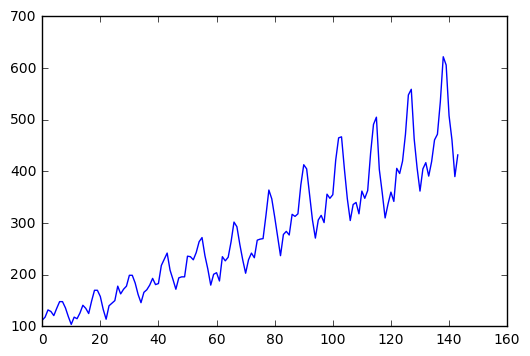

In [123]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()


In [124]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [125]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(96, 48)


In [126]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[i + look_back, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [356]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [357]:
trainX.shape, trainY.shape

((94, 1, 1), (94,))

In [358]:
testX.shape, testY.shape

((46, 1, 1), (46,))

Используя torch.nn.LSTM сделать решить задачу предсказания временного ряда
1. one to one
2. many to many

Попробовать разные размеры окон и torch.nn.GRU вместо LSTM


In [359]:
import tqdm
import torch
from torch import nn, autograd
from torch.autograd import Variable

In [ ]:
x_train = Variable(torch.from_numpy(trainX).type(torch.FloatTensor), requires_grad=False)
y_train = Variable(torch.from_numpy(trainY), requires_grad=False)

x_test = Variable(torch.from_numpy(testX).type(torch.FloatTensor), volatile=True)
y_test = Variable(torch.from_numpy(testY), volatile=True)

One to one:

In [486]:
class MyRecNetOne2One(nn.Module):
    
    def __init__(self):
        super(MyRecNetOne2One, self).__init__()
        self.lstm = nn.LSTM(look_back, 1)

    def forward(self, x, hidden=None):
        return self.lstm(x, hidden)

In [487]:
network = MyRecNetOne2One()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2, weight_decay=1e-03)
criterion = torch.nn.MSELoss()

In [490]:
losses_train = []
losses_test = []

for epoch in tqdm.tnrange(500):
        
    y_pred_train, (h, c) = network(x_train)
    loss_train = criterion(y_pred_train, y_train)
    losses_train.append(loss_train.data[0])
        
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    y_pred_test, (h, c) = network(x_test)
    loss_test = criterion(y_pred_test, y_test)
    losses_test.append(loss_test.data[0])
        
    if epoch % 50 == 0:
        print "loss on train: %.5f, loss on test: %.5f" % (np.mean(losses_train), np.mean(losses_test))

loss on train: 0.15442, loss on test: 0.57156
loss on train: 0.08762, loss on test: 0.41381
loss on train: 0.06419, loss on test: 0.34988
loss on train: 0.04661, loss on test: 0.26802
loss on train: 0.03645, loss on test: 0.21327
loss on train: 0.02989, loss on test: 0.17567
loss on train: 0.02546, loss on test: 0.15050
loss on train: 0.02228, loss on test: 0.13272
loss on train: 0.01989, loss on test: 0.11953
loss on train: 0.01803, loss on test: 0.10936



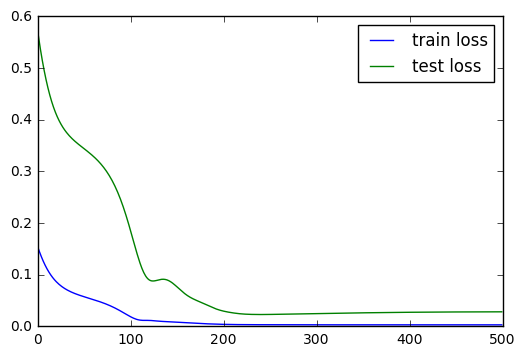

In [491]:
plt.plot(losses_train, label="train loss")
plt.plot(losses_test, label="test loss")
plt.legend()

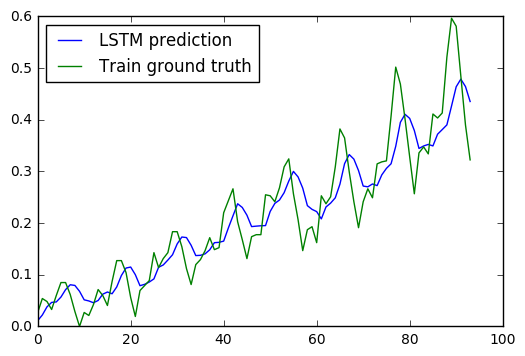

In [499]:
network.eval()
y_pred, (h, c) = network(x_train)
plt.plot(y_pred.data.numpy().ravel(), label="LSTM prediction")
plt.plot(trainY, label="Train ground truth")
plt.legend(loc="best")

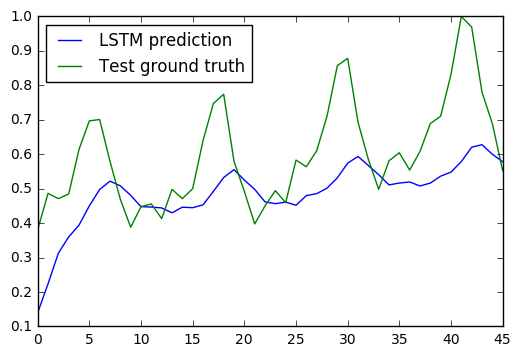

In [501]:
y_pred, (h, c) = network(x_test)
plt.plot(y_pred.data.numpy().ravel(), label="LSTM prediction")
plt.plot(testY, label="Test ground truth")
plt.legend(loc="best")

In [502]:
class MyRecNetOne2OneGRU(nn.Module):
    
    def __init__(self):
        super(MyRecNetOne2One, self).__init__()
        self.lstm = nn.GRU(look_back, 1)

    def forward(self, x, hidden=None):
        return self.lstm(x, hidden)

In [503]:
network2 = MyRecNetOne2One()
optimizer = torch.optim.Adam(network2.parameters(), lr=1e-2, weight_decay=1e-03)
criterion = torch.nn.MSELoss()

In [504]:
losses_train = []
losses_test = []

for epoch in tqdm.tnrange(500):
        
    y_pred_train, (h, c) = network2(x_train)
    loss_train = criterion(y_pred_train, y_train)
    losses_train.append(loss_train.data[0])
        
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    y_pred_test, (h, c) = network2(x_test)
    loss_test = criterion(y_pred_test, y_test)
    losses_test.append(loss_test.data[0])
        
    if epoch % 50 == 0:
        print "loss on train: %.5f, loss on test: %.5f" % (np.mean(losses_train), np.mean(losses_test))

loss on train: 0.32605, loss on test: 0.77901
loss on train: 0.12983, loss on test: 0.46092
loss on train: 0.07981, loss on test: 0.35695
loss on train: 0.05804, loss on test: 0.28729
loss on train: 0.04619, loss on test: 0.24252
loss on train: 0.03841, loss on test: 0.20868
loss on train: 0.03279, loss on test: 0.18154
loss on train: 0.02858, loss on test: 0.15982
loss on train: 0.02536, loss on test: 0.14273
loss on train: 0.02286, loss on test: 0.12928



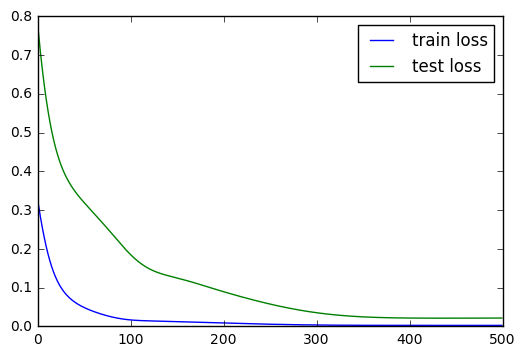

In [505]:
plt.plot(losses_train, label="train loss")
plt.plot(losses_test, label="test loss")
plt.legend()

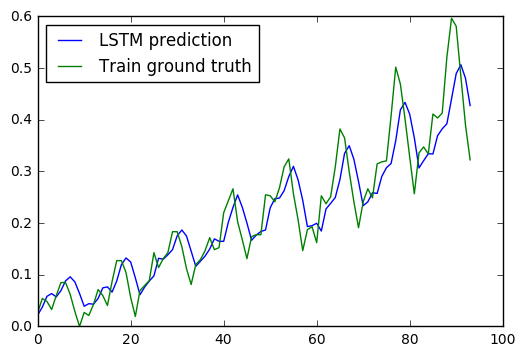

In [507]:
network2.eval()
y_pred, (h, c) = network2(x_train)
plt.plot(y_pred.data.numpy().ravel(), label="LSTM prediction")
plt.plot(trainY, label="Train ground truth")
plt.legend(loc="best")

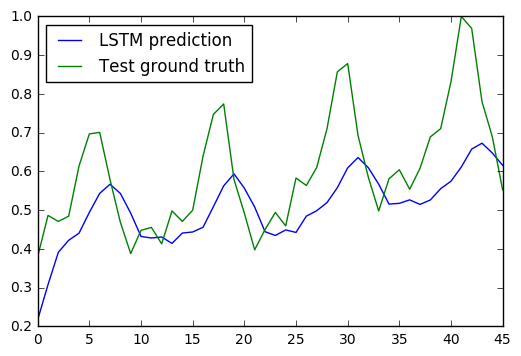

In [508]:
y_pred, (h, c) = network2(x_test)
plt.plot(y_pred.data.numpy().ravel(), label="LSTM prediction")
plt.plot(testY, label="Test ground truth")
plt.legend(loc="best")

## Задание 2

Сделать датасет из двоичных чисел содежащих по N цифр. 
Обучить RNN: (2N -> N) - (2 числа записанные друг за другом) -> (сложение по модулю 2 ** N) . 